The following code imports and analyzes facebook advertising data, with the goal of developing a predictive model for ad conversions

In [1]:
import pandas as pd
import math
import os
import sys
from pathlib import Path
import csv
import seaborn as sn
import numpy as np

from matplotlib import pyplot

import multiprocessing as mp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
os.chdir('C:/Users/Bridget Marie Yoga/Documents/GitPy/Python')

Due to file being non-ideal (missing values, trailing commas in some rows), it is best to clean up the data before importing it into our enviornment

In [3]:
filename = Path('data.csv')
newname = filename.parent/f"{filename.stem}-fixed{filename.suffix}"

BADCOLS = ['', '']

with open(filename, newline='') as infile, open(newname, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    for row in csv.reader(infile):
        if row[-2:] == BADCOLS:
            row[3:3] = BADCOLS
            del row[-2:]
        writer.writerow(row)

# test it

ads = pd.read_csv(newname, header=None)
print(ads)

           0                1              2            3               4   \
0       ad_id  reporting_start  reporting_end  campaign_id  fb_campaign_id   
1      708746       17/08/2017     17/08/2017          916          103916   
2      708749       17/08/2017     17/08/2017          916          103917   
3      708771       17/08/2017     17/08/2017          916          103920   
4      708815       30/08/2017     30/08/2017          916          103928   
...       ...              ...            ...          ...             ...   
1139  1314410       19/08/2017     19/08/2017          NaN             NaN   
1140  1314411       19/08/2017     19/08/2017          NaN             NaN   
1141  1314412       19/08/2017     19/08/2017          NaN             NaN   
1142  1314414       17/08/2017     17/08/2017          NaN             NaN   
1143  1314415       17/08/2017     17/08/2017          NaN             NaN   

         5       6          7          8          9            

In [4]:
#Rename columns
ads.columns = ads.iloc[0]
ads = ads.drop(0)

ads.head()
print(ads.dtypes) 

0
ad_id                  object
reporting_start        object
reporting_end          object
campaign_id            object
fb_campaign_id         object
age                    object
gender                 object
interest1              object
interest2              object
interest3              object
impressions            object
clicks                 object
spent                  object
total_conversion       object
approved_conversion    object
dtype: object


In [5]:
#Adjust type for columns via apply()
ads[['impressions', 'clicks','spent','total_conversion', 'approved_conversion']] = ads[['impressions', 'clicks','spent','total_conversion', 'approved_conversion']].apply(pd.to_numeric) 
ads['reporting_start'] = pd.to_datetime(ads['reporting_start'])
ads['reporting_end'] = pd.to_datetime(ads['reporting_end'])

ads['day_of_week'] = ads['reporting_start'].dt.day_name()

In [6]:
#Create custom marketing values
ads['cost_per_click'] = ads['spent'] / ads['clicks']

#df['day_of_week'] = df['my_dates'].dt.day_name()

#ads['cost_per_acquisition'] =ads['spent'].astype('int32') / ads['approved_conversion'].astype('int32')


Exploratory data analysis

In [7]:
ads.describe()

,impressions,clicks,spent,total_conversion,approved_conversion,cost_per_click
count,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000,936.000000
mean,1.867321e+05,33.390201,51.360656,2.855643,0.944007,1.499347
std,3.127622e+05,56.892438,86.908418,4.483593,1.737708,0.232879
min,8.700000e+01,0.000000,0.000000,0.000000,0.000000,0.180000
25%,6.503500e+03,1.000000,1.480000,1.000000,0.000000,1.390000
50%,5.150900e+04,8.000000,12.370000,1.000000,1.000000,1.498273
75%,2.217690e+05,37.500000,60.025000,3.000000,1.000000,1.644364
max,3.052003e+06,421.000000,639.949998,60.000000,21.000000,2.212000


age     30-34  35-39  40-44  45-49
gender                            
F         197    109    107    138
M         229    139    103    121


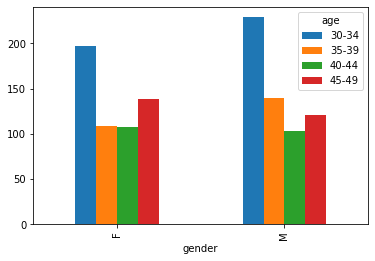

In [8]:
impressions_by_gender = pd.pivot_table(ads,index = 'gender', columns = 'age', values = 'impressions',aggfunc = np.count_nonzero)
impressions_by_gender.plot.bar()
print(impressions_by_gender)

0            approved_conversion
campaign_id                     
1178                         378
916                           24
936                          183


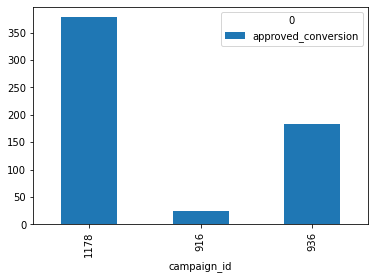

In [9]:
conversions_by_campaign = pd.pivot_table(ads,index = 'campaign_id', values = 'approved_conversion',aggfunc = np.sum)
conversions_by_campaign.plot.bar()
print(conversions_by_campaign)

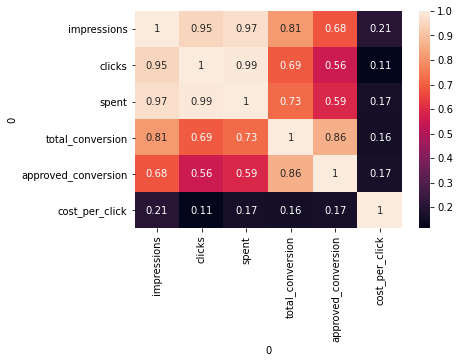

In [10]:
corrMatrix = ads.corr()
sn.heatmap(corrMatrix, annot=True)


Create model pipelines for: Data imputation, scaling, and best fit model identificatio 

In [11]:
def label_convert(row):
    if row['approved_conversion'] == 0:
        return 0
    else:
        return 1

In [12]:
ads['true_convert'] = ads.apply (lambda row: label_convert(row), axis=1)

In [13]:
#Removed certain columns based on previous iterations to hone in on characteristics we can control in our reporting strategy
x = ads.drop(columns=['approved_conversion','total_conversion','reporting_start','reporting_end', 'ad_id','fb_campaign_id','true_convert','cost_per_click'])
y = ads['true_convert']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.33, random_state=85)

In [14]:
x.columns

Index(['campaign_id', 'age', 'gender', 'interest1', 'interest2', 'interest3',
       'impressions', 'clicks', 'spent', 'day_of_week'],
      dtype='object', name=0)

In [15]:
y_train.value_counts()

1    391
0    374
Name: true_convert, dtype: int64

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [17]:
numeric_features = ads.select_dtypes(include=['int64', 'float64']).drop(['approved_conversion','total_conversion', 'true_convert','cost_per_click'], axis=1).columns
categorical_features = ads.select_dtypes(include=['object']).drop([ 'ad_id','fb_campaign_id'],axis=1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [18]:
numeric_features

Index(['impressions', 'clicks', 'spent'], dtype='object', name=0)

In [19]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(random_state=42)]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(x_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(x_test, y_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 0.532
SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model score: 0.526
NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=True, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
model score: 0.611
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                  

With the best model identified, leverage GridSearchCV() to optimize hyperparameters

In [20]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

param_grid = [{
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }]

n_cpus = mp.cpu_count()
#Does this make sense with scoring and refit different scores?
gridsearch = GridSearchCV(GradientBoostingClassifier(), param_grid, n_jobs= n_cpus,verbose=0.5, scoring='f1',refit='accuracy_score',cv=2)

In [21]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('gridsearch', gridsearch)])
pipe.fit(x_train, y_train)
#print(pipe.best_params_)    
#print(pipe.best_score_)

Fitting 2 folds for each of 84672 candidates, totalling 169344 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 1088 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 3296 tasks      | elapsed:   18.7s
[Parallel(n_jobs=8)]: Done 6376 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done 10352 tasks      | elapsed:   51.4s
[Parallel(n_jobs=8)]: Done 15200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 20936 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 27544 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 35048 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 43424 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 52688 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 62824 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 73856 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 85760 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 98552 tasks      | el

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [22]:
pipe[1]

GridSearchCV(cv=2, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
       0.28181818

Identify key feature importances of facebook ad campaigns

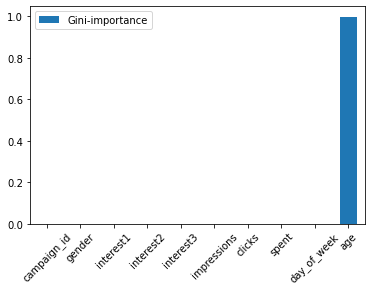

In [24]:
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

importance = gridsearch.best_estimator_.feature_importances_

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, importance):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [ ]:
print(importances)